# Experiment 4 (Notebook)

This notebook is a direct conversion of `experiment4.py`.

Changes applied (only visualization settings):
- Plot/figure background: `#252629`
- Text (titles, labels, tick labels, legend): white

The simulation logic in the original script is unchanged.


In [5]:
# Plot styling (applies globally to all matplotlib figures in this notebook)
import matplotlib as mpl

BG = "#252629"

mpl.rcParams.update({
    "figure.facecolor": BG,
    "axes.facecolor": BG,
    "savefig.facecolor": BG,
    "text.color": "white",
    "axes.labelcolor": "white",
    "axes.edgecolor": "white",
    "axes.titlecolor": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "legend.edgecolor": "white",
    "grid.color": "white",
})

# Optional: make saved figures keep the background even if code uses transparent saves
mpl.rcParams["savefig.transparent"] = False


Output directory set to: /Users/igorzakrocki/Library/CloudStorage/OneDrive-AkademiaGórniczo-Hutniczaim.StanisławaStaszicawKrakowie/AGH/IDS_9/Informatyka Systemów Złożonych/CS_radiotherapy_project/figures/sim_04
Generowanie danych treningowych z PDE...


/var/folders/fb/cs3xytzn26l5b5y0jfq3dw0w0000gn/T/ipykernel_57885/1828122736.py:96: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  mass_pde[0] = np.trapz(u, x)
/var/folders/fb/cs3xytzn26l5b5y0jfq3dw0w0000gn/T/ipykernel_57885/1828122736.py:116: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  mass_pde[n] = np.trapz(u, x)


Liczba próbek treningowych: 23984
Rozpoczynam trening NODE...
Epoch 0: Loss = 0.005296
Epoch 50: Loss = 0.001144
Epoch 100: Loss = 0.001076
Epoch 150: Loss = 0.001000
Epoch 200: Loss = 0.000806
Epoch 250: Loss = 0.000800


/var/folders/fb/cs3xytzn26l5b5y0jfq3dw0w0000gn/T/ipykernel_57885/1828122736.py:283: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  current_mass = np.trapz(u0, x)
/var/folders/fb/cs3xytzn26l5b5y0jfq3dw0w0000gn/T/ipykernel_57885/1828122736.py:251: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  current_mass = np.trapz(u0, x) # to jest to samo co mean*L


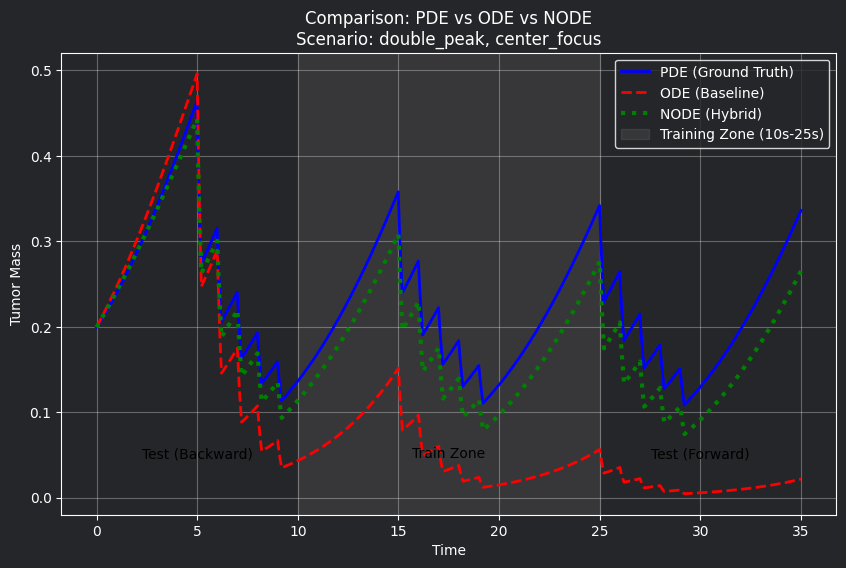

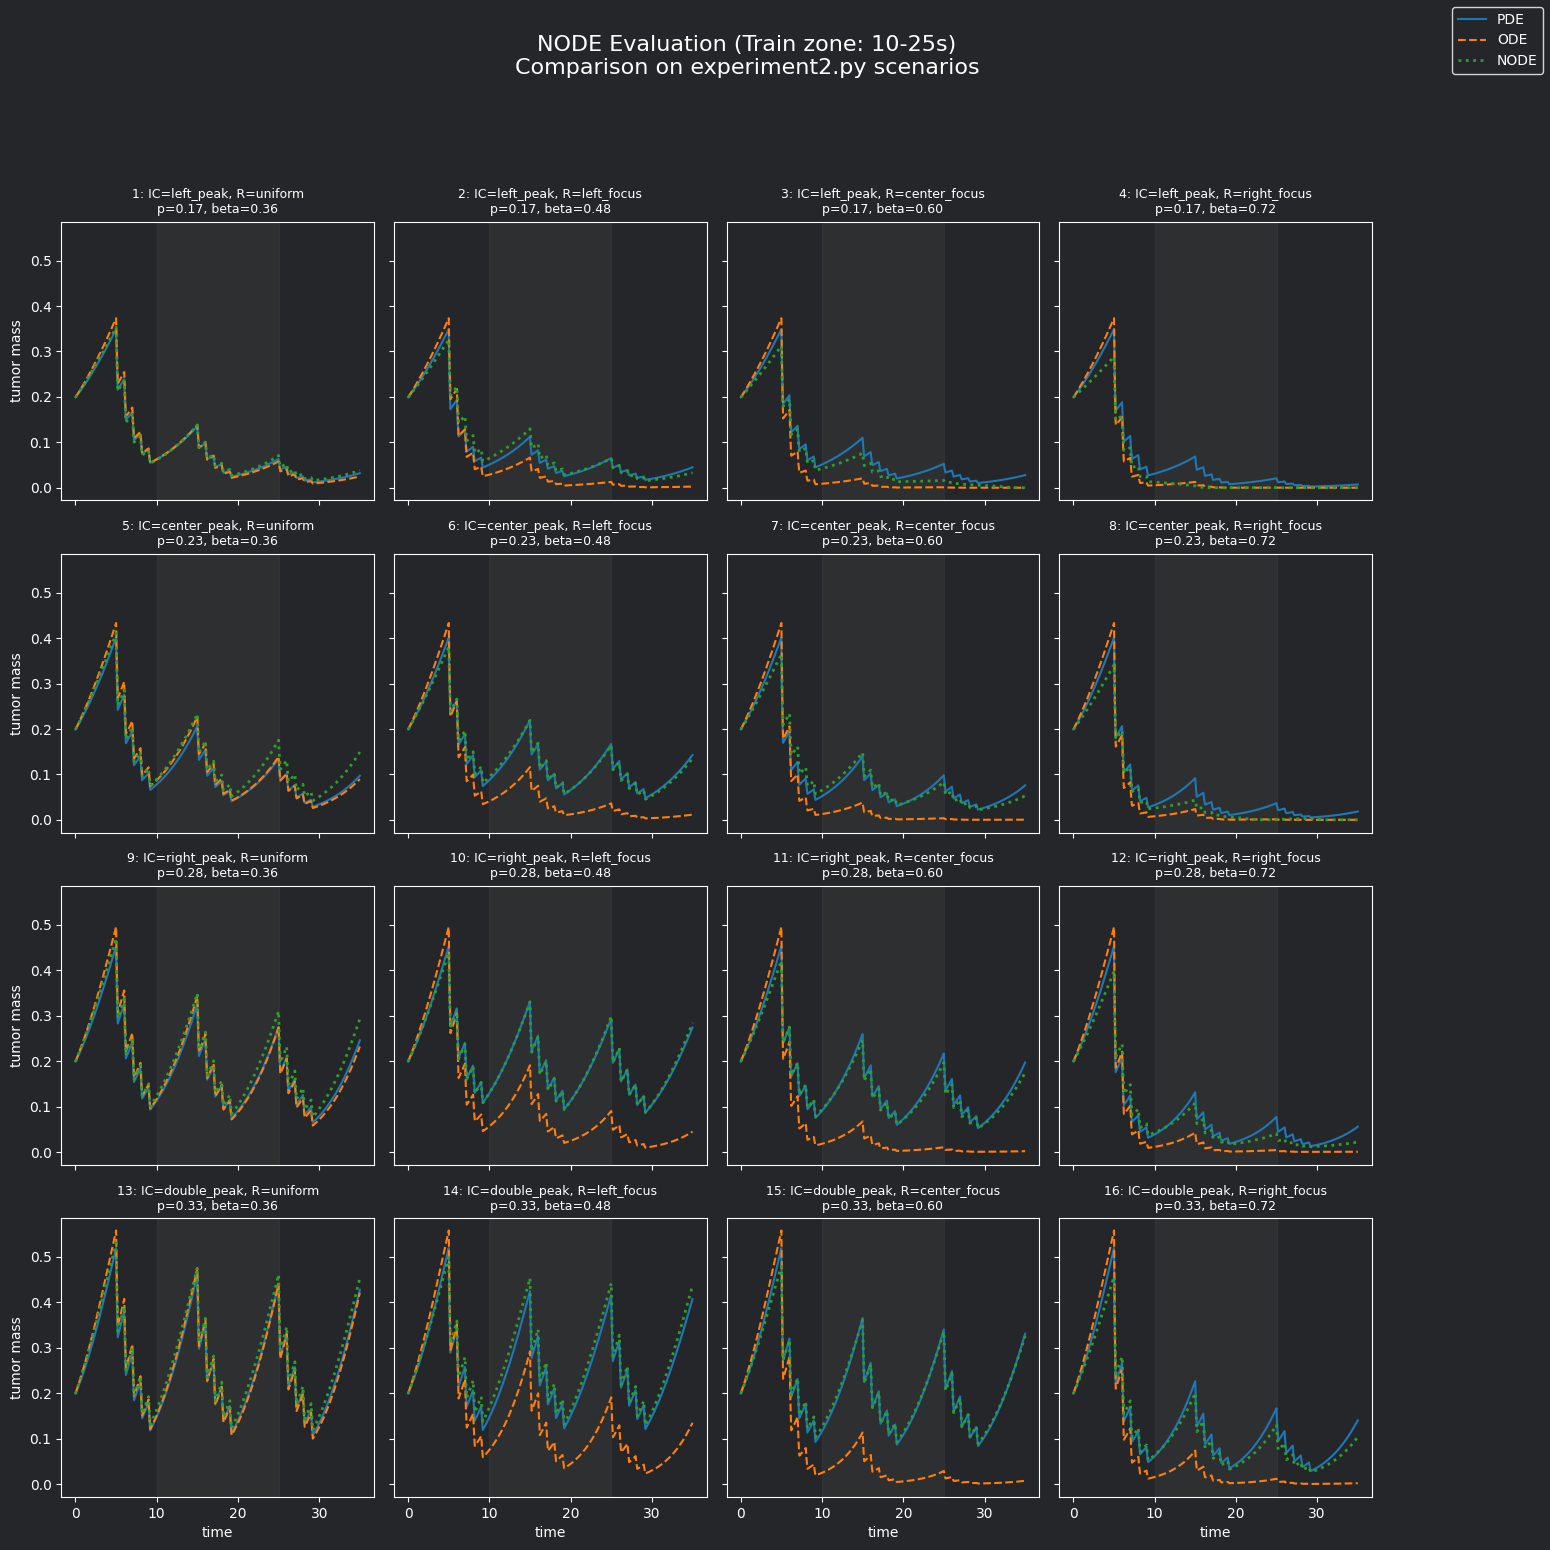

Gotowe. Wygenerowano pliki w: ../figures/sim_04


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from pathlib import Path

# Default output directory for plots/animations
DEFAULT_OUTPUT_DIR = Path('../figures/sim_04')
DEFAULT_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
print(f"Output directory set to: {DEFAULT_OUTPUT_DIR.resolve()}")

# ============================================================
# 1. PARAMETRY I FUNKCJE Z EXPERIMENT2.PY (BEZ ZMIAN)
# ============================================================

# Global spatial / temporal setup
L = 1.0
N = 101
x = np.linspace(0.0, L, N)
dx = x[1] - x[0]

T_END = 35.0
dt = 0.01
NSTEPS = int(T_END / dt)

# Base biophysical parameters
D_base = 0.001
rho_base = 0.25
beta_base = 0.6
K = 1.0

# Hypoxia profile
H_vec = 0.4 + 0.6 * np.exp(-((x - 0.5 * L) / 0.5) ** 2)

# Temporal dose schedule
def dose_rate_time(t):
    dose_amp = 4.0
    fraction_duration = 0.2
    course_starts = [5.0, 15.0, 25.0]

    for cs in course_starts:
        for n in range(5):
            t_start = cs + n * 1.0
            t_end = t_start + fraction_duration
            if t_start <= t <= t_end:
                return dose_amp
    return 0.0

# Spatial patterns (copied exactly from experiment2.py)
def initial_condition(kind, x):
    if kind == "left_peak":
        u0 = 0.1 + 0.5 * np.exp(-((x - 0.2) / 0.1) ** 2)
    elif kind == "center_peak":
        u0 = 0.1 + 0.5 * np.exp(-((x - 0.5) / 0.1) ** 2)
    elif kind == "right_peak":
        u0 = 0.1 + 0.5 * np.exp(-((x - 0.8) / 0.1) ** 2)
    elif kind == "double_peak":
        u0 = (0.05 + 0.35 * np.exp(-((x - 0.25) / 0.07) ** 2)
                   + 0.35 * np.exp(-((x - 0.75) / 0.07) ** 2))
    else:
        u0 = 0.2 * np.ones_like(x)
    
    u = np.clip(u0, 0.0, 1.0)
    # Normalizacja z experiment2.py
    return u / np.sum(u) * 20

def dose_profile(kind, x):
    if kind == "uniform":
        W = np.ones_like(x)
    elif kind == "left_focus":
        W = 0.2 + 0.8 * np.exp(-((x - 0.2) / 0.1) ** 2)
    elif kind == "center_focus":
        W = 0.2 + 0.8 * np.exp(-((x - 0.5) / 0.1) ** 2)
    elif kind == "right_focus":
        W = 0.2 + 0.8 * np.exp(-((x - 0.8) / 0.1) ** 2)
    else:
        W = np.ones_like(x)

    # Normalizacja z experiment2.py
    W = W / np.sum(W)
    return W * 200

# ============================================================
# 2. DEFINICJE MODELI: PDE (Ground Truth), ODE (Baseline), NODE
# ============================================================

def run_pde_simulation(D, rho, beta, u0, W):
    """Dokładna symulacja PDE z experiment2.py zwracająca średnią w czasie"""
    u = u0.copy()
    times = np.zeros(NSTEPS + 1)
    mass_pde = np.zeros(NSTEPS + 1) # Mass = integral(u) ~ sum(u)*dx ~ mean(u)*L

    times[0] = 0.0
    mass_pde[0] = np.trapz(u, x)

    for n in range(1, NSTEPS + 1):
        t = n * dt
        
        # PDE Step
        u_xx = np.zeros_like(u)
        u_xx[1:-1] = (u[2:] - 2 * u[1:-1] + u[:-2]) / dx**2
        u_xx[0] = 2 * (u[1] - u[0]) / dx**2
        u_xx[-1] = 2 * (u[-2] - u[-1]) / dx**2

        r_t = dose_rate_time(t)
        R_xt = r_t * W
        kill_term = beta * R_xt * H_vec * u

        du_dt = D * u_xx + rho * u * (1.0 - u / K) - kill_term
        u = u + dt * du_dt
        u = np.clip(u, 0.0, 1.0) # Clip physical bounds

        times[n] = t
        mass_pde[n] = np.trapz(u, x)

    return times, mass_pde

def physics_ode_derivative(U_mass, r_t, rho, beta, WH_mean):
    """Czysta pochodna z modelu ODE (experiment2.py logic).
    Uwaga: w exp2 U to 'mean density', tutaj pracujemy na 'mass' = U*L.
    Ponieważ L=1.0, Mass == Mean.
    """
    U = U_mass # bo L=1
    
    # Równanie z experiment2.py:
    # dU_dt = rho * U * (1.0 - U / K) - beta * r_t * WH_mean * U
    
    growth = rho * U * (1.0 - U / K)
    kill = beta * r_t * WH_mean * U
    return growth - kill

# --- MODEL SIECI NEURONOWEJ (MLP) ---
class ResidualMLP(nn.Module):
    def __init__(self):
        super().__init__()
        # Wejście: [Mass, r(t), rho, beta, WH_mean] -> 5 cech
        self.net = nn.Sequential(
            nn.Linear(5, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1) # Wyjście: Poprawka do dU/dt
        )

    def forward(self, mass, r_t, rho, beta, wh_mean):
        # Sklejenie wejść w jeden tensor
        x_in = torch.stack([mass, r_t, rho, beta, wh_mean], dim=1)
        return self.net(x_in)

# ============================================================
# 3. GENEROWANIE DANYCH TRENINGOWYCH (ŚRODKOWY ZAKRES)
# ============================================================

print("Generowanie danych treningowych z PDE...")

# Parametry do gridu 4x4 (używamy ich do treningu aby pokryć przestrzeń)
ic_kinds = ["left_peak", "center_peak", "right_peak", "double_peak"]
dose_kinds = ["uniform", "left_focus", "center_focus", "right_focus"]
rho_factors = [0.7, 0.9, 1.1, 1.3]
beta_factors = [0.6, 0.8, 1.0, 1.2]

X_train = []
y_train = []

# Zakres treningowy (t od 10 do 25)
T_TRAIN_START = 10.0
T_TRAIN_END = 25.0

# Generujemy dane dla wszystkich kombinacji z gridu 4x4
for i, ic_name in enumerate(ic_kinds):
    for j, dose_name in enumerate(dose_kinds):
        rho = rho_base * rho_factors[i]
        beta = beta_base * beta_factors[j]
        
        u0 = initial_condition(ic_name, x)
        W = dose_profile(dose_name, x)
        WH_mean = np.mean(W * H_vec) # Parametr dla ODE

        times, mass_pde = run_pde_simulation(D_base, rho, beta, u0, W)

        # Wycinamy tylko środek symulacji
        mask = (times >= T_TRAIN_START) & (times < T_TRAIN_END)
        indices = np.where(mask)[0]
        
        # Tworzymy pary (stan_t -> stan_t+1)
        for idx in indices[:-1]: # bez ostatniego, bo nie ma następnika w oknie
            t_curr = times[idx]
            m_curr = mass_pde[idx]
            m_next_target = mass_pde[idx+1]
            
            r_curr = dose_rate_time(t_curr)
            
            # Obliczamy ile "powinno" wyjść z czystego ODE
            # Żeby sieć uczyła się tylko RÓŻNICY (Residual)
            d_ode = physics_ode_derivative(m_curr, r_curr, rho, beta, WH_mean)
            m_next_ode = m_curr + dt * d_ode
            
            # Targetem dla sieci jest różnica między prawdą (PDE) a baseline (ODE)
            # Chcemy: m_curr + dt*(ode + mlp) = m_next_target
            # Czyli: mlp_target = (m_next_target - m_next_ode) / dt
            
            mlp_target = (m_next_target - m_next_ode) / dt

            X_train.append([m_curr, r_curr, rho, beta, WH_mean])
            y_train.append([mlp_target])

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

print(f"Liczba próbek treningowych: {len(X_train)}")

# ============================================================
# 4. TRENING NODE
# ============================================================

model = ResidualMLP()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()
dataset = TensorDataset(X_train, y_train)
loader = DataLoader(dataset, batch_size=256, shuffle=True)

print("Rozpoczynam trening NODE...")
for epoch in range(300): # Krótki trening wystarczy
    model.train()
    epoch_loss = 0
    for xb, yb in loader:
        optimizer.zero_grad()
        # Rozpakowanie wejść dla czytelności forwardu
        preds = model(xb[:,0], xb[:,1], xb[:,2], xb[:,3], xb[:,4])
        loss = loss_fn(preds, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    if epoch % 50 == 0:
        print(f"Epoch {epoch}: Loss = {epoch_loss/len(loader):.6f}")

# ============================================================
# 5. FUNKCJA INTEGROWANIA (NODE STEPPER)
# ============================================================

def run_node_simulation(model, u0, rho, beta, W):
    """Symulacja całego przebiegu używając NODE (ODE + MLP)"""
    model.eval()
    times = np.linspace(0, T_END, NSTEPS + 1)
    mass_node = np.zeros(NSTEPS + 1)
    
    # Inicjalizacja tak jak w ODE (średnia z u0)
    current_mass = np.trapz(u0, x) # to jest to samo co mean*L
    mass_node[0] = current_mass
    
    WH_mean = np.mean(W * H_vec)
    
    with torch.no_grad():
        for n in range(NSTEPS):
            t = times[n]
            r_t = dose_rate_time(t)
            
            # 1. Oblicz fizykę
            d_phys = physics_ode_derivative(current_mass, r_t, rho, beta, WH_mean)
            
            # 2. Oblicz poprawkę z sieci
            # Tensor wejściowy: [mass, r, rho, beta, wh_mean]
            inputs = torch.tensor([current_mass, r_t, rho, beta, WH_mean], dtype=torch.float32)
            inputs = inputs.unsqueeze(0) # batch dim
            d_corr = model(inputs[:,0], inputs[:,1], inputs[:,2], inputs[:,3], inputs[:,4]).item()
            
            # 3. Krok Eulera
            # NODE: dM/dt = physics + correction
            current_mass += dt * (d_phys + d_corr)
            current_mass = max(current_mass, 0.0) # Fizyczne ograniczenie
            
            mass_node[n+1] = current_mass
            
    return times, mass_node

def run_pure_ode_simulation(u0, rho, beta, W):
    """Wrapper dla czystego ODE do celów wykresu"""
    times = np.linspace(0, T_END, NSTEPS + 1)
    mass_ode = np.zeros(NSTEPS + 1)
    current_mass = np.trapz(u0, x)
    mass_ode[0] = current_mass
    WH_mean = np.mean(W * H_vec)
    
    for n in range(NSTEPS):
        t = times[n]
        r_t = dose_rate_time(t)
        d_phys = physics_ode_derivative(current_mass, r_t, rho, beta, WH_mean)
        current_mass += dt * d_phys
        current_mass = max(current_mass, 0.0)
        mass_ode[n+1] = current_mass
    return times, mass_ode


# ============================================================
# 6. TWORZENIE WYKRESÓW
# ============================================================

# --- WYKRES 1: Szczegółowe porównanie z wyszarzeniem strefy ---
# Wybieramy jeden ciekawy przypadek (np. double_peak + center_focus)
test_ic = "double_peak"
test_dose = "center_focus"
rho_test = rho_base * 1.1
beta_test = beta_base * 0.8

u0_test = initial_condition(test_ic, x)
W_test = dose_profile(test_dose, x)

t_axis, m_pde = run_pde_simulation(D_base, rho_test, beta_test, u0_test, W_test)
_, m_ode = run_pure_ode_simulation(u0_test, rho_test, beta_test, W_test)
_, m_node = run_node_simulation(model, u0_test, rho_test, beta_test, W_test)

plt.figure(figsize=(10, 6))
plt.plot(t_axis, m_pde, 'b-', linewidth=2, label='PDE (Ground Truth)')
plt.plot(t_axis, m_ode, 'r--', linewidth=2, label='ODE (Baseline)')
plt.plot(t_axis, m_node, 'g:', linewidth=3, label='NODE (Hybrid)')

# Wyszarzenie strefy treningowej
plt.axvspan(T_TRAIN_START, T_TRAIN_END, color='gray', alpha=0.2, label='Training Zone (10s-25s)')

# Adnotacje
plt.text(5, max(m_pde)*0.1, "Test (Backward)", ha='center', color='black')
plt.text(17.5, max(m_pde)*0.1, "Train Zone", ha='center', color='black')
plt.text(30, max(m_pde)*0.1, "Test (Forward)", ha='center', color='black')

plt.xlabel("Time")
plt.ylabel("Tumor Mass")
plt.title(f"Comparison: PDE vs ODE vs NODE\nScenario: {test_ic}, {test_dose}")
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(DEFAULT_OUTPUT_DIR / "experiment4_comparison.png")
plt.show()

# --- WYKRES 2: Grid 4x4 (Zgodny z experiment2.py) ---

fig, axes = plt.subplots(4, 4, figsize=(16, 16), sharex=True, sharey=True)

scenario_idx = 0
for i, ic_name in enumerate(ic_kinds):
    for j, dose_name in enumerate(dose_kinds):
        scenario_idx += 1
        
        # Pobranie parametrów z list (tak jak w exp2)
        rho = rho_base * rho_factors[i]
        beta = beta_base * beta_factors[j]
        
        u0 = initial_condition(ic_name, x)
        W = dose_profile(dose_name, x)
        
        # Symulacje
        ts, m_pde = run_pde_simulation(D_base, rho, beta, u0, W)
        _, m_ode = run_pure_ode_simulation(u0, rho, beta, W)
        _, m_node = run_node_simulation(model, u0, rho, beta, W)
        
        ax = axes[i, j]
        ax.plot(ts, m_pde, label="PDE")
        ax.plot(ts, m_ode, "--", label="ODE")
        ax.plot(ts, m_node, ":", linewidth=2, label="NODE")
        
        # Oznaczenie strefy treningowej
        ax.axvspan(T_TRAIN_START, T_TRAIN_END, color='gray', alpha=0.1)

        ax.set_title(
            f"{scenario_idx}: IC={ic_name}, R={dose_name}\n"
            f"p={rho:.2f}, beta={beta:.2f}", fontsize=9
        )

        if i == 3:
            ax.set_xlabel("time")
        if j == 0:
            ax.set_ylabel("tumor mass")

# Global legend
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right")
fig.suptitle(
    "NODE Evaluation (Train zone: 10-25s)\n"
    "Comparison on experiment2.py scenarios",
    fontsize=16
)

fig.tight_layout(rect=[0.03, 0.03, 0.9, 0.93])
plt.savefig(DEFAULT_OUTPUT_DIR / "experiment4_grid.png")
plt.show()

print("Gotowe. Wygenerowano pliki w:", DEFAULT_OUTPUT_DIR)